<a href="https://colab.research.google.com/github/Hubi1001/Project-OCR/blob/main/Projekt_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Importowanie bibliotek



In [51]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import random
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")

print(f"Keras version: {keras.__version__}")

print("GPU dostępne:", "TAK" if tf.config.list_physical_devices('GPU') else "NIE")

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU dostępne: NIE


### 2. Definicja znaków polskich



In [52]:
POLISH_CHARS = [
  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
  'a', 'ą', 'b', 'c', 'ć', 'd', 'e', 'ę', 'f', 'g', 'h',
  'i', 'j', 'k', 'l', 'ł', 'm', 'n', 'ń', 'o', 'ó', 'p',
  'r', 's', 'ś', 't', 'u', 'w', 'y', 'z', 'ź', 'ż',
  'A', 'Ą', 'B', 'C', 'Ć', 'D', 'E', 'Ę', 'F', 'G', 'H',
  'I', 'J', 'K', 'L', 'Ł', 'M', 'N', 'Ń', 'O', 'Ó', 'P',
  'R', 'S', 'Ś', 'T', 'U', 'W', 'Y', 'Z', 'Ź', 'Ż'
]
NUM_CLASSES = len(POLISH_CHARS)
char_to_idx = {char: idx for idx, char in enumerate(POLISH_CHARS)}
idx_to_char = {idx: char for idx, char in enumerate(POLISH_CHARS)}

print(f"Liczba klas: {NUM_CLASSES}")

print(f"Znaki: {' '.join(POLISH_CHARS)}")

Liczba klas: 74
Znaki: 0 1 2 3 4 5 6 7 8 9 a ą b c ć d e ę f g h i j k l ł m n ń o ó p r s ś t u w y z ź ż A Ą B C Ć D E Ę F G H I J K L Ł M N Ń O Ó P R S Ś T U W Y Z Ź Ż


### 3. Generator syntetycznych danych treningowych

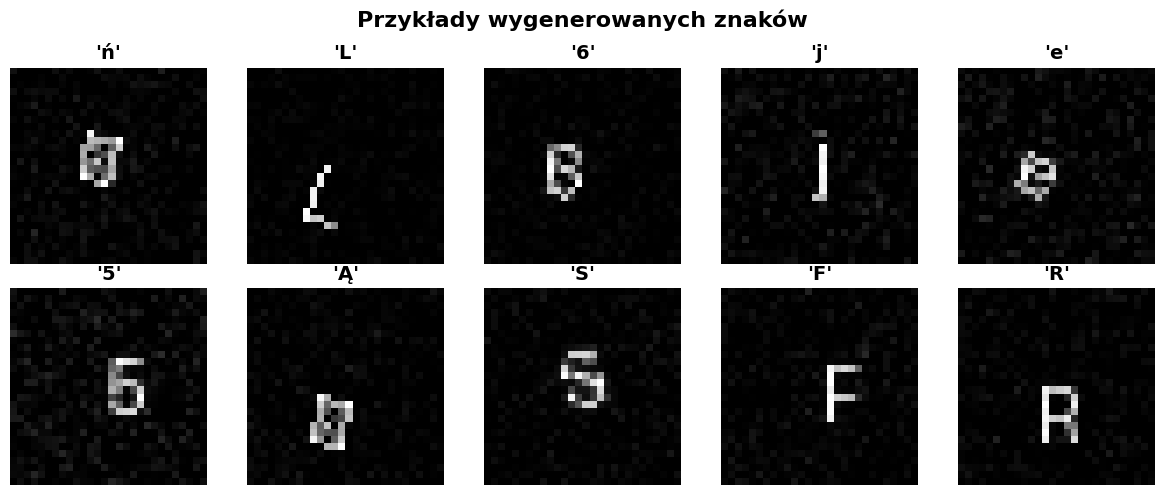

In [53]:
def generate_synthetic_handwriting(char, img_size=28):
  """
  Teraz wygeneruję syntetyczny obraz pisma odręcznego dla danego znaku
  """
  # Tworzenie obrazu
  img = Image.new('L', (img_size, img_size), color=0)
  draw = ImageDraw.Draw(img)

  # Randomizacja parametrów
  font_size = random.randint(16, 24)
  rotation = random.uniform(-25, 25)
  offset_x = random.randint(-3, 3)
  offset_y = random.randint(-3, 3)

  # Próba użycia różnych fontów
  try:
    # Lista popularnych fontów
    font_options = [
      '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',

      '/System/Library/Fonts/Helvetica.ttc',

      'C:\\Windows\\Fonts\\arial.ttf',

      'arial.ttf'
    ]

    font = None

    for font_path in font_options:
      try:
        font = ImageFont.truetype(font_path, font_size)
        break
      except:
        continue
    if font is None:
      font = ImageFont.load_default()
  except:
    font = ImageFont.load_default()

  # Rysowanie znaku
  bbox = draw.textbbox((0, 0), char, font=font)
  text_width = bbox[2] - bbox[0]
  text_height = bbox[3] - bbox[1]

  position = (
    (img_size - text_width) // 2 + offset_x,
    (img_size - text_height) // 2 + offset_y
  )

  draw.text(position, char, fill=255, font=font)
  # Rotacja
  if abs(rotation) > 0:
    img = img.rotate(rotation, fillcolor=0, expand=False)

  # Dodanie szumu
  img_array = np.array(img, dtype=np.float32)
  noise = np.random.normal(0, random.uniform(5, 15), img_array.shape)
  img_array = np.clip(img_array + noise, 0, 255)

  # Losowe rozmycie
  if random.random() > 0.5:

    img = Image.fromarray(img_array.astype(np.uint8))
    img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 0.5)))
    img_array = np.array(img)

  # Normalizacja
  img_array = img_array / 255.0
  return img_array

# Testowanie generatora
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
test_chars = random.sample(POLISH_CHARS, 10)

for idx, (ax, char) in enumerate(zip(axes.flat, test_chars)):

  img = generate_synthetic_handwriting(char)
  ax.imshow(img, cmap='gray')
  ax.set_title(f"'{char}'", fontsize=14, weight='bold')
  ax.axis('off')

plt.suptitle('Przykłady wygenerowanych znaków', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

 ### 4. Generowanie pełnego zbioru danych

In [54]:
def generate_dataset(samples_per_char=100, img_size=28):
  """
  Generuje kompletny zbiór danych
  """
  X = []
  y = []

  print("Generowanie danych treningowych...")

  for idx, char in enumerate(POLISH_CHARS):
    if idx % 10 == 0:
      print(f"Postęp: {idx}/{NUM_CLASSES} znaków...")

    for _ in range(samples_per_char):

      img = generate_synthetic_handwriting(char, img_size)
      X.append(img)
      y.append(idx)

  X = np.array(X)
  y = np.array(y)

  # Dodanie wymiaru kanału
  X = X.reshape(-1, img_size, img_size, 1)

  print(f"\nWygenerowano:")
  print(f" - Obrazów: {X.shape[0]}")
  print(f" - Klas: {NUM_CLASSES}")
  print(f" - Kształt obrazu: {X.shape[1:]}")

  return X, y

# Generowanie danych

X, y = generate_dataset(samples_per_char=100)

# Podział na zbiory treningowy i testowy

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nPodział danych:")
print(f" - Trening: {X_train.shape[0]} próbek")
print(f" - Test: {X_test.shape[0]} próbek")

Generowanie danych treningowych...
Postęp: 0/74 znaków...
Postęp: 10/74 znaków...
Postęp: 20/74 znaków...
Postęp: 30/74 znaków...
Postęp: 40/74 znaków...
Postęp: 50/74 znaków...
Postęp: 60/74 znaków...
Postęp: 70/74 znaków...

Wygenerowano:
 - Obrazów: 7400
 - Klas: 74
 - Kształt obrazu: (28, 28, 1)

Podział danych:
 - Trening: 5920 próbek
 - Test: 1480 próbek


### 5. Wizualizacja przykładów z każdej klasy



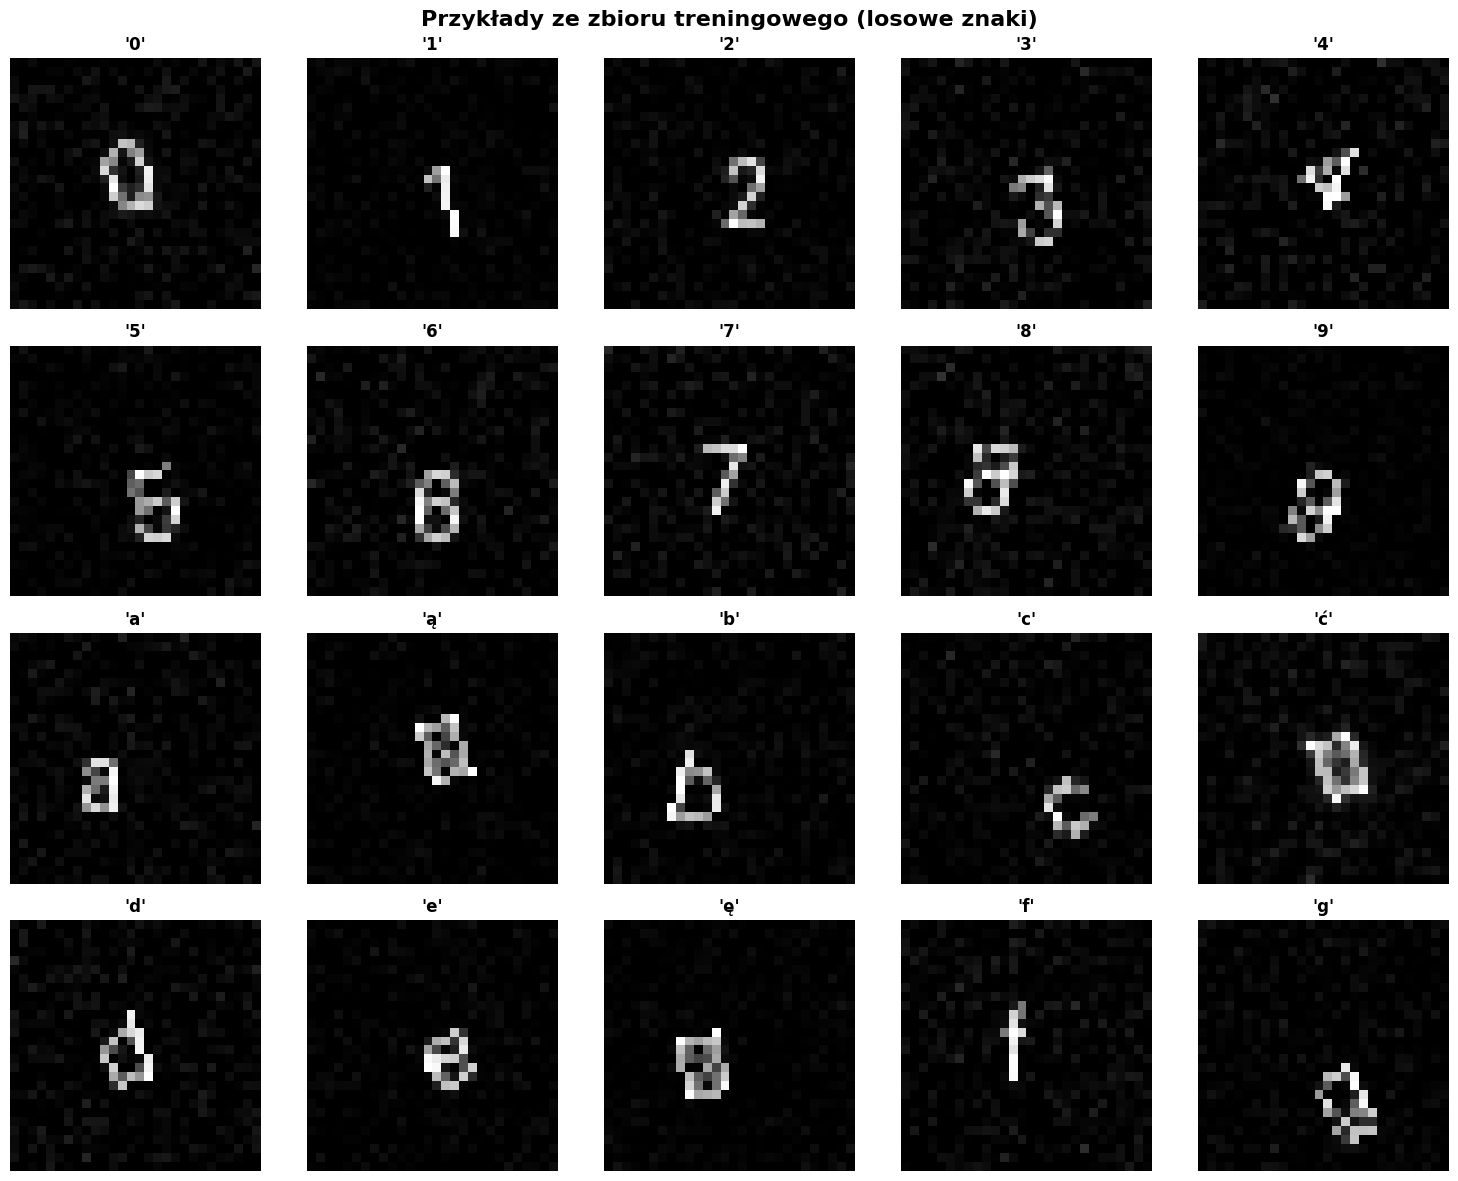

In [55]:
# Wyświetlenie przykładów z każdej klasy

n_display = min(20, NUM_CLASSES)
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for idx in range(n_display):

  row = idx // 5
  col = idx % 5

  # Znajdź pierwszy przykład dla tej klasy

  class_idx = np.where(y_train == idx)[0][0]
  img = X_train[class_idx]

  axes[row, col].imshow(img.squeeze(), cmap='gray')
  axes[row, col].set_title(f"'{POLISH_CHARS[idx]}'", fontsize=12, weight='bold')
  axes[row, col].axis('off')

plt.suptitle('Przykłady ze zbioru treningowego (losowe znaki)', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

### 6. Definicja architektury modelu CNN



In [56]:
def create_cnn_model(input_shape=(28, 28, 1), num_classes=NUM_CLASSES):
  """
  Tworzy model CNN do rozpoznawania pisma
  """
  model = keras.Sequential([

    # Warstwa wejściowa
    layers.Input(shape=input_shape),

    # Pierwszy blok konwolucyjny
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Drugi blok konwolucyjny
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Trzeci blok konwolucyjny

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Warstwy gęste

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Warstwa wyjściowa
    layers.Dense(num_classes, activation='softmax')
  ])
  return model

# Tworzenie modelu
model = create_cnn_model()

# Kompilacja
model.compile(

  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)
# Podsumowanie architektury
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           51

 Total params: 479,274 (1.83 MB)

 Trainable params: 477,866 (1.82 MB)

 Non-trainable params: 1,408 (5.50 KB)

### 7. Augmentacja danych



Augmentacja danych skonfigurowana:
 - Rotacja: ±10%
 - Zoom: ±10%
 - Przesunięcie: ±10%


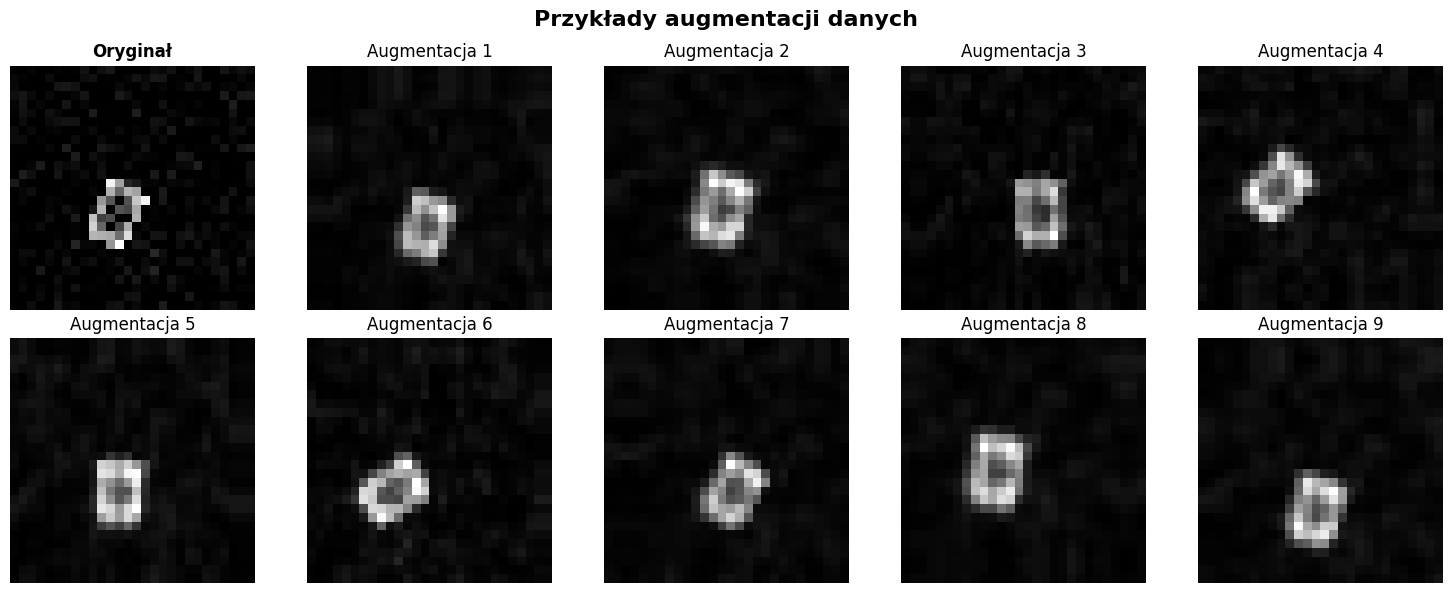

In [57]:
# Augmentacja danych dla lepszej generalizacji

data_augmentation = keras.Sequential([
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomTranslation(0.1, 0.1),
])

print("Augmentacja danych skonfigurowana:")
print(" - Rotacja: ±10%")
print(" - Zoom: ±10%")
print(" - Przesunięcie: ±10%")

# Wizualizacja augmentacji
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
sample_img = X_train[0:1]

for idx, ax in enumerate(axes.flat):
  if idx == 0:
    ax.imshow(sample_img.squeeze(), cmap='gray')
    ax.set_title('Oryginał', fontsize=12, weight='bold')
  else:
    augmented = data_augmentation(sample_img, training=True)
    ax.imshow(augmented.numpy().squeeze(), cmap='gray')
    ax.set_title(f'Augmentacja {idx}', fontsize=12)
  ax.axis('off')

plt.suptitle('Przykłady augmentacji danych', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

### 8. Callbacks i konfiguracja treningu



In [58]:
# Definicja callbacks
callbacks = [
  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
  ),

  keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
  ),

  keras.callbacks.ModelCheckpoint(
    'best_polish_handwriting_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
  )
]
print("Callbacks skonfigurowane:")
print(" ✓ Early Stopping (patience=7)")
print(" ✓ Learning Rate Reduction (factor=0.5)")
print(" ✓ Model Checkpoint (save best)")

Callbacks skonfigurowane:
 ✓ Early Stopping (patience=7)
 ✓ Learning Rate Reduction (factor=0.5)
 ✓ Model Checkpoint (save best)


### 9. Trening modelu

In [59]:
# Parametry treningu
EPOCHS = 30
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.15

print(f"Rozpoczynam trening modelu...")
print(f" - Epoki: {EPOCHS}")
print(f" - Batch size: {BATCH_SIZE}")
print(f" - Walidacja: {VALIDATION_SPLIT*100}%")
print(f" - Liczba parametrów: {model.count_params():,}")
print("\n" + "="*60)
# Trening
history = model.fit(
  X_train, y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT,
  callbacks=callbacks,
  verbose=1
)

print("\n" + "="*60)
print("Trening zakończony!")

Rozpoczynam trening modelu...
 - Epoki: 30
 - Batch size: 64
 - Walidacja: 15.0%
 - Liczba parametrów: 479,274

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.0116 - loss: 5.3415
Epoch 1: val_accuracy improved from -inf to 0.01126, saving model to best_polish_handwriting_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 434ms/step - accuracy: 0.0117 - loss: 5.3395 - val_accuracy: 0.0113 - val_loss: 4.7930 - learning_rate: 0.0010
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.0299 - loss: 4.7899
Epoch 2: val_accuracy did not improve from 0.01126
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 405ms/step - accuracy: 0.0299 - loss: 4.7889 - val_accuracy: 0.0113 - val_loss: 6.6087 - learning_rate: 0.0010
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.0468 - loss: 4.3637
Epoch 3: val_accuracy did not improve from 0.01126
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 397ms/step - accuracy: 0.0468 - loss: 4.3626 - val_accuracy: 0.0113 - val_loss: 8.3000 - learning_rate: 0.00

### 10. Wizualizacja historii treningu

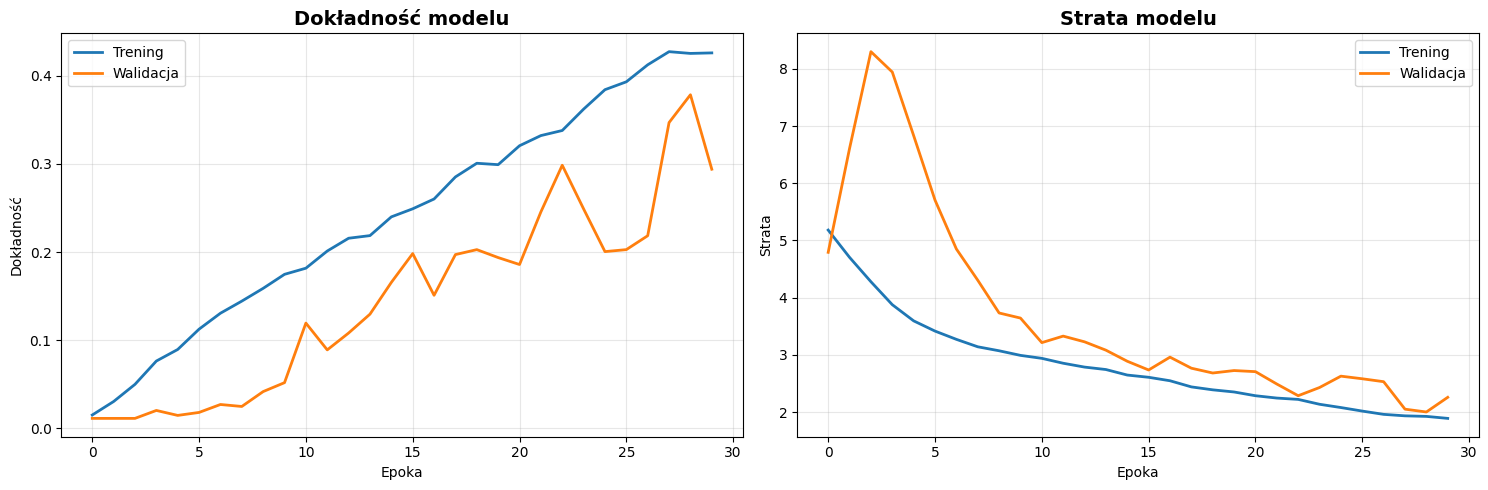


Najlepsza dokładność walidacyjna: 0.3784 (epoka 29)


In [60]:
# Wykres dokładności
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Dokładność
ax1.plot(history.history['accuracy'], label='Trening', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Walidacja', linewidth=2)
ax1.set_title('Dokładność modelu', fontsize=14, weight='bold')
ax1.set_xlabel('Epoka')
ax1.set_ylabel('Dokładność')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Strata
ax2.plot(history.history['loss'], label='Trening', linewidth=2)
ax2.plot(history.history['val_loss'], label='Walidacja', linewidth=2)
ax2.set_title('Strata modelu', fontsize=14, weight='bold')
ax2.set_xlabel('Epoka')
ax2.set_ylabel('Strata')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Najlepsza dokładność
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"\nNajlepsza dokładność walidacyjna: {best_val_acc:.4f} (epoka {best_epoch})")

### 11. Ewaluacja na zbiorze testowym

Ewaluacja na zbiorze testowym...

WYNIKI NA ZBIORZE TESTOWYM:
 Dokładność: 0.3919 (39.19%)
 Strata:   1.9388


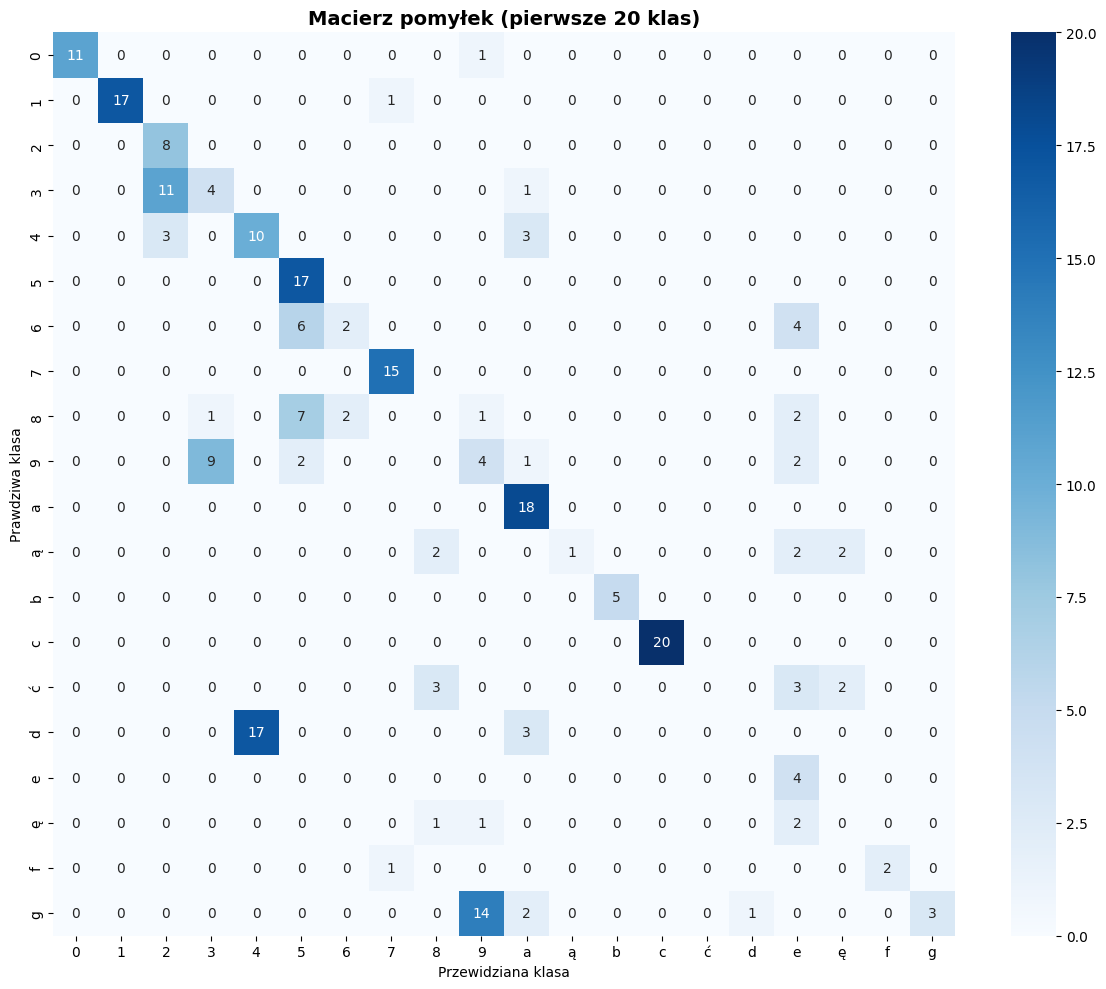

In [61]:
# Ewaluacja
print("Ewaluacja na zbiorze testowym...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*60}")
print(f"WYNIKI NA ZBIORZE TESTOWYM:")
print(f"{'='*60}")
print(f" Dokładność: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f" Strata:   {test_loss:.4f}")
print(f"{'='*60}")

# Predykcje
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Macierz pomyłek (wizualizacja fragmentu)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_classes)

# Wyświetlenie fragmentu macierzy (pierwszych 20 klas)
n_show = min(20, NUM_CLASSES)
plt.figure(figsize=(12, 10))
sns.heatmap(
  cm[:n_show, :n_show],
  annot=True,
  fmt='d',
  cmap='Blues',
  xticklabels=POLISH_CHARS[:n_show],
  yticklabels=POLISH_CHARS[:n_show]
)

plt.title(f'Macierz pomyłek (pierwsze {n_show} klas)', fontsize=14, weight='bold')
plt.ylabel('Prawdziwa klasa')
plt.xlabel('Przewidziana klasa')
plt.tight_layout()
plt.show()

### 12. Analiza błędów

Liczba błędnych predykcji: 900 / 1480


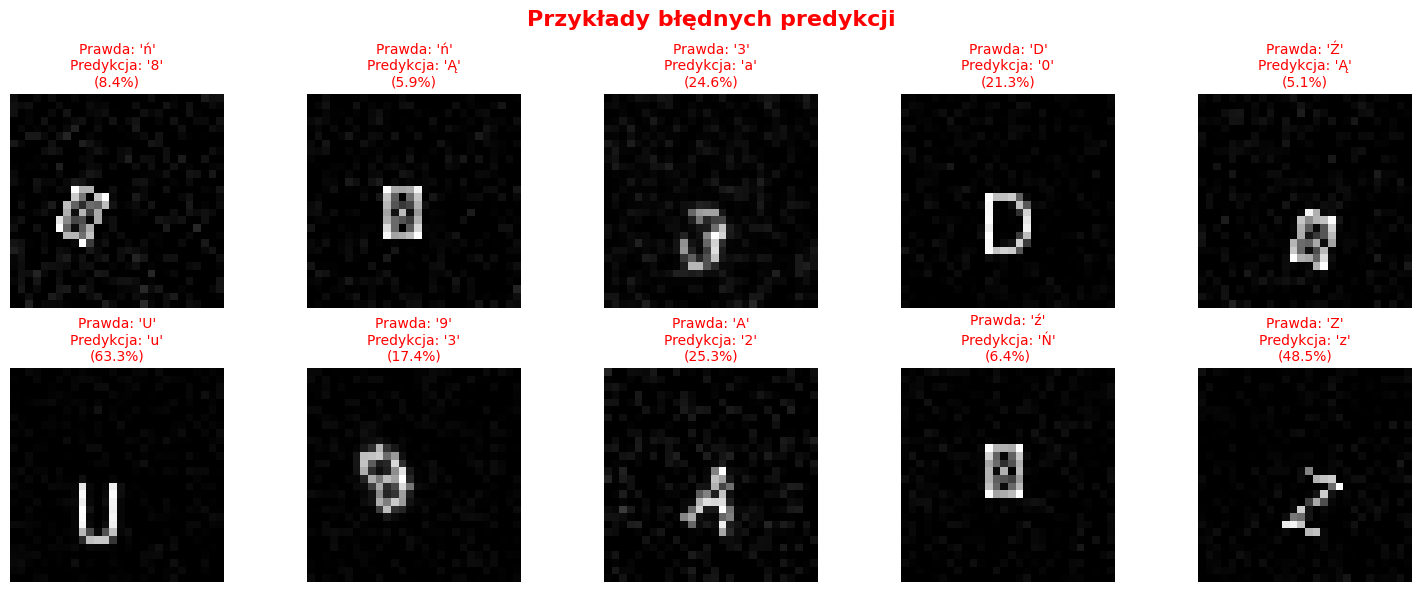

In [62]:
# Znalezienie przykładów błędnych predykcji
wrong_indices = np.where(y_pred_classes != y_test)[0]
print(f"Liczba błędnych predykcji: {len(wrong_indices)} / {len(y_test)}")

if len(wrong_indices) > 0:
  # Wyświetlenie przykładów błędów
  n_errors = min(10, len(wrong_indices))
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))

  for idx, ax in enumerate(axes.flat):
    if idx < n_errors:
      error_idx = wrong_indices[idx]
      img = X_test[error_idx]
      true_label = POLISH_CHARS[y_test[error_idx]]
      pred_label = POLISH_CHARS[y_pred_classes[error_idx]]
      confidence = y_pred[error_idx][y_pred_classes[error_idx]] * 100

      ax.imshow(img.squeeze(), cmap='gray')
      ax.set_title(

        f"Prawda: '{true_label}'\nPredykcja: '{pred_label}'\n({confidence:.1f}%)",
        fontsize=10,
        color='red'
      )
    ax.axis('off')

  plt.suptitle('Przykłady błędnych predykcji', fontsize=16, weight='bold', color='red')
  plt.tight_layout()
  plt.show()

### 13. Test na losowych przykładach

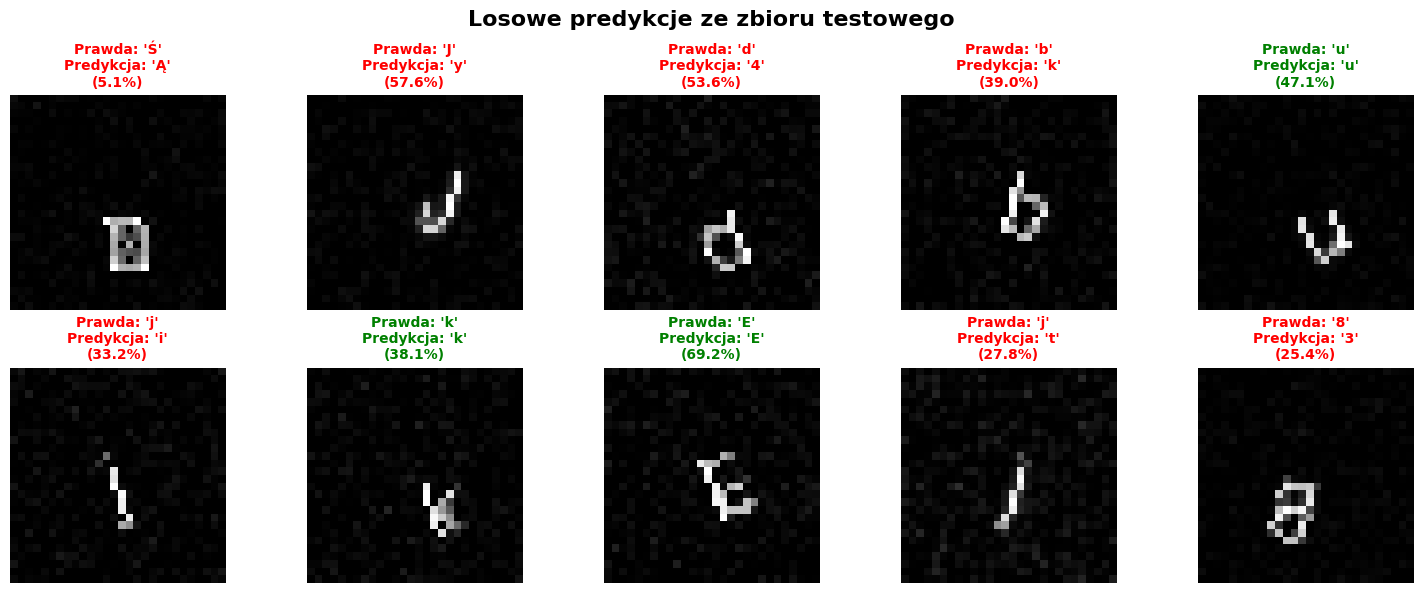

In [63]:
# Funkcja do predykcji z wizualizacją
def predict_and_visualize(model, images, true_labels, n_samples=10):
  """
  Wykonuje predykcję i wizualizuje wyniki
  """
  indices = random.sample(range(len(images)), n_samples)
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))

  for idx, ax in enumerate(axes.flat):
    img_idx = indices[idx]
    img = images[img_idx]
    true_label = POLISH_CHARS[true_labels[img_idx]]

    # Predykcja
    pred = model.predict(img.reshape(1, 28, 28, 1), verbose=0)
    pred_class = np.argmax(pred[0])
    pred_label = POLISH_CHARS[pred_class]
    confidence = pred[0][pred_class] * 100

    # Wyświetlenie
    ax.imshow(img.squeeze(), cmap='gray')

    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(

      f"Prawda: '{true_label}'\nPredykcja: '{pred_label}'\n({confidence:.1f}%)",
      fontsize=10,
      color=color,
      weight='bold'
    )
    ax.axis('off')

  plt.suptitle('Losowe predykcje ze zbioru testowego', fontsize=16, weight='bold')
  plt.tight_layout()
  plt.show()
# Test
predict_and_visualize(model, X_test, y_test, n_samples=10)

### 14. Zapisanie modelu

In [64]:
# Zapisanie finalnego modelu
model.save('polish_handwriting_final.keras')
print("✓ Model zapisany jako 'polish_handwriting_final.keras'")

# Zapisanie architektury jako JSON
model_json = model.to_json()
with open('model_architecture.json', 'w') as json_file:
  json_file.write(model_json)
print("✓ Architektura zapisana jako 'model_architecture.json'")

# Zapisanie mapowania klas
np.save('class_mapping.npy', {'char_to_idx': char_to_idx, 'idx_to_char': idx_to_char})
print("✓ Mapowanie klas zapisane jako 'class_mapping.npy'")

print("\n" + "="*60)
print("PODSUMOWANIE:")
print("="*60)
print(f" Całkowita liczba próbek: {len(X):,}")
print(f" Liczba klas: {NUM_CLASSES}")
print(f" Dokładność testowa: {test_accuracy*100:.2f}%")
print(f" Parametry modelu: {model.count_params():,}")
print("="*60)

✓ Model zapisany jako 'polish_handwriting_final.keras'
✓ Architektura zapisana jako 'model_architecture.json'
✓ Mapowanie klas zapisane jako 'class_mapping.npy'

PODSUMOWANIE:
 Całkowita liczba próbek: 7,400
 Liczba klas: 74
 Dokładność testowa: 39.19%
 Parametry modelu: 479,274


### 15. Funkcja do predykcji własnych obrazów

In [65]:
# Funkcja do predykcji z wizualizacją
def predict_custom_image(model, image_path_or_array):
  """
  Przewiduje znak z własnego obrazu
  Args:
    model: wytrenowany model
    image_path_or_array: ścieżka do obrazu lub numpy array
  """
  # Wczytanie obrazu
  if isinstance(image_path_or_array, str):

    img = Image.open(image_path_or_array).convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img)
  else:
    img_array = image_path_or_array

  # Normalizacja
  img_array = img_array / 255.0
  img_array = img_array.reshape(1, 28, 28, 1)

  # Predykcja
  pred = model.predict(img_array, verbose=0)

  # Top 5 predykcji
  top5_idx = np.argsort(pred[0])[-5:][::-1]

  print("\nTop 5 predykcji:")
  print("-" * 40)

  for i, idx in enumerate(top5_idx, 1):
    char = POLISH_CHARS[idx]
    prob = pred[0][idx] * 100
    print(f"{i}. '{char}' - {prob:.2f}%")

  # Wizualizacja
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  ax1.imshow(img_array.squeeze(), cmap='gray')
  ax1.set_title('Wejściowy obraz', fontsize=12, weight='bold')
  ax1.axis('off')

  top5_chars = [POLISH_CHARS[i] for i in top5_idx]
  top5_probs = [pred[0][i] * 100 for i in top5_idx]

  ax2.barh(range(5), top5_probs, color='steelblue')
  ax2.set_yticks(range(5))
  ax2.set_yticklabels([f"'{c}'" for c in top5_chars])
  ax2.set_xlabel('Prawdopodobieństwo (%)')
  ax2.set_title('Top 5 predykcji', fontsize=12, weight='bold')
  ax2.invert_yaxis()

  for i, v in enumerate(top5_probs):
    ax2.text(v + 1, i, f'{v:.1f}%', va='center')

  plt.tight_layout()
  plt.show()

  return POLISH_CHARS[top5_idx[0]], pred[0][top5_idx[0]]

print("Funkcja predict_custom_image() gotowa do użycia!")
print("\nPrzykład użycia:")
print(" char, confidence = predict_custom_image(model, 'moj_obraz.png')")

Funkcja predict_custom_image() gotowa do użycia!

Przykład użycia:
 char, confidence = predict_custom_image(model, 'moj_obraz.png')


## Testowanie wielu obrazów

### Subtask:
Zaproponuj, jak wczytać i przetworzyć wiele rzeczywistych obrazów z folderu i wykonać na nich predykcje.

In [67]:
# Testowanie wielu obrazów z folderu
import os
def predict_on_folder(model, folder_path='custom_images'):
  """
  Wykonuje predykcję na wszystkich obrazach w podanym folderze.
  """
  print(f"Przetwarzanie obrazów z folderu: {folder_path}")
  print("="*40)

  if not os.path.exists(folder_path):
    print(f"Błąd: Folder '{folder_path}' nie istnieje.")
    return

  image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

  if not image_files:
    print(f"Brak obrazów w folderze '{folder_path}' (obsługiwane formaty: .png, .jpg, .jpeg).")
    return

  for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    print(f"\nPrzetwarzanie pliku: {image_file}")

    try:
      # Użyj funkcji predict_custom_image do wczytania, przetworzenia i predykcji
      predicted_char, confidence = predict_custom_image(model, image_path)

      print(f" - Przewidziany znak: '{predicted_char}'")
      print(f" - Pewność: {confidence*100:.2f}%")

    except Exception as e:
      print(f"Błąd podczas przetwarzania pliku {image_file}: {e}")

# Użyj funkcji do przetworzenia obrazów w folderze 'custom_images'
predict_on_folder(model, 'custom_images')

print("\n" + "="*40)
print("Zakończono przetwarzanie obrazów z folderu.")

Przetwarzanie obrazów z folderu: custom_images
Błąd: Folder 'custom_images' nie istnieje.

Zakończono przetwarzanie obrazów z folderu.


### 16. Test na nowo wygenerowanych obrazach

Generowanie nowych testowych przykładów...



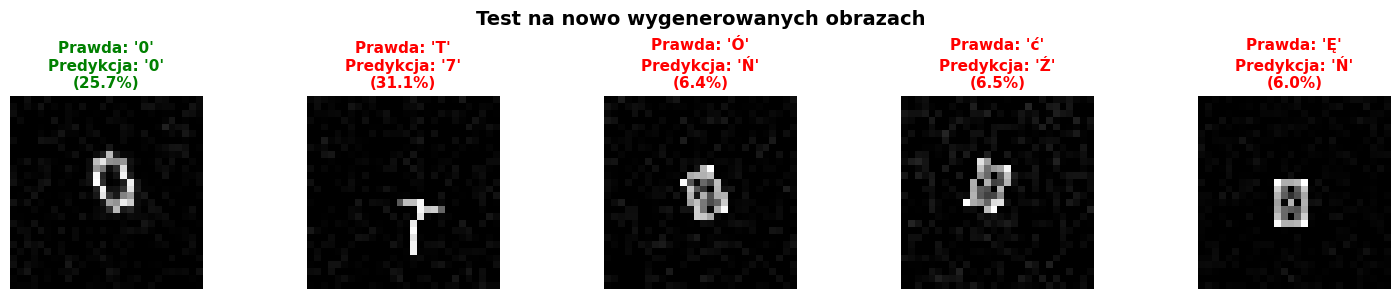

In [68]:
# Generowanie nowych testowych obrazów (niewidzianych przez model)
print("Generowanie nowych testowych przykładów...\n")

test_chars = random.sample(POLISH_CHARS, 5)
new_images = [generate_synthetic_handwriting(char) for char in test_chars]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for idx, (ax, char, img) in enumerate(zip(axes, test_chars, new_images)):
  # Predykcja
  img_input = img.reshape(1, 28, 28, 1)
  pred = model.predict(img_input, verbose=0)
  pred_class = np.argmax(pred[0])
  pred_char = POLISH_CHARS[pred_class]
  confidence = pred[0][pred_class] * 100

  # Wizualizacja
  ax.imshow(img, cmap='gray')
  color = 'green' if pred_char == char else 'red'
  ax.set_title(
    f"Prawda: '{char}'\nPredykcja: '{pred_char}'\n({confidence:.1f}%)",
    fontsize=11,
    color=color,
    weight='bold'
  )
  ax.axis('off')

plt.suptitle('Test na nowo wygenerowanych obrazach', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

### Gotowe!

Model został wytrenowany i jest gotowy do użycia. Możesz:

# 1. **Zapisać model**: `model.save('moj_model.keras')`
# 2. **Wczytać model**: `model = keras.models.load_model('moj_model.keras')`
# 3. **Użyć do predykcji**: `predict_custom_image(model, 'obraz.png')`

### Następne kroki:

# - Zwiększ liczbę próbek per znak dla lepszej dokładności
# - Dodaj więcej augmentacji danych
# - Eksperymentuj z architekturą sieci
# - Zbierz rzeczywiste próbki pisma odręcznego